# Libraries

In [ ]:
!pip install sodapy

In [ ]:
import pandas as pd
import holidays
import datetime
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt

# Data Collection

## Liquor Sales

In [ ]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
q = """
  select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek, name as StoreName, Zipcode, City, County, category_name, sale_liters, sale_dollars, state_bottle_retail
  where date_extract_y(date) >= 2022
  LIMIT 100000
"""
results = client.get("m3tr-qhgy", query=q)
df_liquor = pd.DataFrame.from_records(results)

In [ ]:
df_liquor["DayOfWeek"].value_counts()

2    21406
3    20168
5    19961
4    18106
1    13469
0     6890
Name: DayOfWeek, dtype: int64

## Colleges

In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

# Data Cleaning

## Functions

In [ ]:
us_holidays = holidays.country_holidays('US', years=range(2012, 2024))
def near_holi(date):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [ ]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

In [ ]:
def classify_college_size(enrollment):
    if enrollment > 10000:
        return "Large"
    elif enrollment > 3000:
        return "Midsize"
    else:
        return "Small"

## Feature Creation/Manipulation

In [ ]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges.rename(columns={"Enrollment[7] (spring 2012)": "Enrollment"}, inplace=True)
df_colleges = df_colleges[["Institution", "City", "Enrollment"]]
df_colleges["City"] = df_colleges["City"].str.upper()

<ipython-input-14-6ef766366104>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["City"] = df_colleges["City"].str.upper()


In [ ]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [ ]:
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor.dropna(subset=['City', 'Zipcode', 'County'], inplace=True)

In [ ]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].map(near_holi)
df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type_cat)
df_liquor["CategoryNum"] = df_liquor["Category"].map(
    {
        "VODKA": 1,
        "WHISKY": 2,
        "RUM": 3,
        "GIN": 4,
        "TEQUILA": 5,
        "BRANDY": 6,
        "SCHNAPPS": 7,
        "SPIRITS": 8,
        "OTHER": 9
      })
df_colleges["Student Pop"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
df_colleges["Student Pop"] = df_colleges["Student Pop"].str.replace(",", "").astype(int)
student_pop = pd.DataFrame(df_colleges.groupby("City")["Student Pop"].sum())
college_count = pd.DataFrame(df_colleges.groupby("City")["Institution"].count())
student_pop = student_pop.merge(college_count, how="left", on="City")
student_pop["Size"] = student_pop["Student Pop"].apply(classify_college_size)
student_pop
# !!!Size is from 2012 data!!!
df_liquor = df_liquor.merge(student_pop, how="left", on="City")

In [ ]:
df_liquor["Institution"].fillna(0, inplace=True)
df_liquor["Student Pop"].fillna(0, inplace=True)
df_liquor["Size"].fillna("None", inplace=True)

In [ ]:
df_liquor['City'] = df_liquor['City'].astype("category")
df_liquor['County'] = df_liquor['County'].astype("category")
df_liquor['category_name'] = df_liquor['category_name'].astype("category")
df_liquor['StoreName'] = df_liquor['StoreName'].astype("category")
df_liquor['Size'] = df_liquor['Size'].astype("category")
df_liquor['Zipcode'] = df_liquor['Zipcode'].astype("category")

In [ ]:
df_liquor.dtypes

Date                   datetime64[ns]
Month                          object
DayOfWeek                      object
StoreName                    category
Zipcode                      category
City                         category
County                       category
category_name                category
sale_liters                   float64
sale_dollars                  float64
state_bottle_retail            object
NearHoliday                     int64
CostPerLiter                  float64
Category                       object
CategoryNum                     int64
Student Pop                   float64
Institution                   float64
Size                         category
dtype: object

In [ ]:
med = df_liquor["sale_liters"].astype(float).describe()["50%"]
df_liquor["Sale Amount"] = df_liquor["sale_liters"].map(lambda y: "Large" if y >= med else "Small")

# Exploration

In [ ]:
df_liquor["Category"].value_counts(normalize=True)

WHISKY      0.274783
VODKA       0.234110
OTHER       0.201909
RUM         0.085939
TEQUILA     0.063932
SCHNAPPS    0.052898
BRANDY      0.039563
SPIRITS     0.024268
GIN         0.022598
Name: Category, dtype: float64

In [ ]:
df_liquor["sale_dollars"].describe()

count    99966.000000
mean       151.305585
std        417.934073
min          1.340000
25%         43.560000
50%         90.000000
75%        163.080000
max      39124.800000
Name: sale_dollars, dtype: float64

In [ ]:
df_liquor[df_liquor["sale_dollars"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,state_bottle_retail,NearHoliday,CostPerLiter,Category,CategoryNum,Student Pop,Institution,Size,Sale Amount


In [ ]:
df_liquor["sale_liters"].describe()

count    99966.000000
mean         8.077099
std         28.410826
min          0.020000
25%          1.500000
50%          4.500000
75%          9.000000
max       2016.000000
Name: sale_liters, dtype: float64

In [ ]:
df_liquor[df_liquor["sale_liters"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,category_name,sale_liters,sale_dollars,state_bottle_retail,NearHoliday,CostPerLiter,Category,CategoryNum,Student Pop,Institution,Size,Sale Amount


In [ ]:
df_liquor["Size"].value_counts(normalize=True)

None       0.481334
Large      0.299382
Midsize    0.129634
Small      0.089650
Name: Size, dtype: float64

<Axes: >

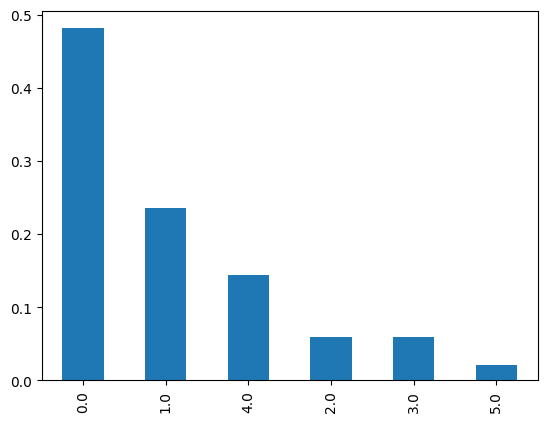

In [ ]:
df_liquor["Institution"].value_counts(normalize=True).plot.bar()

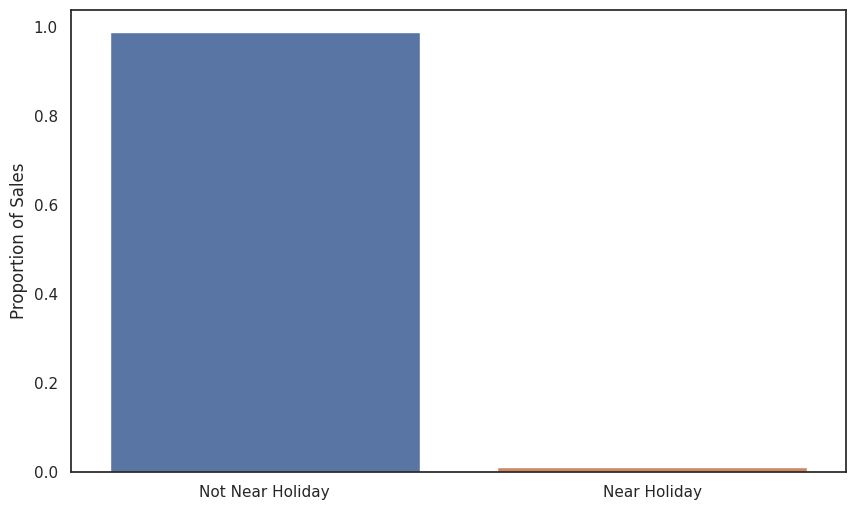

In [ ]:
import seaborn as sns
props = df_liquor['NearHoliday'].value_counts(normalize=True)

sns.set(style="white")

plt.figure(figsize=(10, 6))
sns.barplot(x=["Not Near Holiday", "Near Holiday"], y=props)
plt.ylabel("Proportion of Sales")
# plt.title("")

plt.show()

# Save Data to CSV

In [ ]:
df_liquor.to_csv("client_b", index=False)

# Sources

US Holidays: https://pypi.org/project/holidays/

In [ ]:
us_holidays = holidays.country_holidays('US', years=2012)
for day in us_holidays.items():
    print(day)

(datetime.date(2012, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2012, 2, 20), "Washington's Birthday")
(datetime.date(2012, 10, 8), 'Columbus Day')
(datetime.date(2012, 1, 1), "New Year's Day")
(datetime.date(2012, 1, 2), "New Year's Day (Observed)")
(datetime.date(2012, 5, 28), 'Memorial Day')
(datetime.date(2012, 7, 4), 'Independence Day')
(datetime.date(2012, 9, 3), 'Labor Day')
(datetime.date(2012, 11, 11), 'Veterans Day')
(datetime.date(2012, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2012, 11, 22), 'Thanksgiving')
(datetime.date(2012, 12, 25), 'Christmas Day')


Iowa Colleges: https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa